In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

### Load data 

In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
GS_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/gwas_max_abs_z.top500.gs'

In [3]:
DS_LIST = ['facs', 'droplet', 'aizarani', 'halpern']
DS_LIST = ['facs', 'droplet', 'aizarani']
DS_LIST = ['facs', 'droplet']
DIC_INFO = {}
DIC_INFO['facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}
DIC_INFO['droplet'] = {'species': 'mmusculus', 'dname': 'TMS Droplet'}
# DIC_INFO['aizarani'] = {'species': 'hsapiens', 'dname': 'Human liver'}
# DIC_INFO['halpern'] = {'species': 'mmusculus', 'dname': 'Mouse liver'}

In [4]:
dic_data_raw = {}
dic_data_processed = {}

# TMS FACs 
dic_data_raw['facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')
dic_data_processed['facs'] = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='Liver')['Liver']

# TMS droplet 
dic_data_raw['droplet'] = dl.load_tms_ct(DATA_PATH, data_name='droplet')
dic_data_processed['droplet'] = dl.load_tms_processed(DATA_PATH, data_name='droplet', tissue='Liver')['Liver']

# # Aizarani et al. Liver atlas
# dic_data_raw['aizarani'] = dl.load_aizarani_raw_data(opt='raw')
# dic_data_processed['aizarani'] = dl.load_aizarani_raw_data(opt='processed')

# # Halpern et al. mouse hepatocytes
# dic_data_raw['halpern'] = dl.load_halpern_shenhav_raw_data(opt='raw')
# dic_data_processed['halpern'] = dl.load_halpern_shenhav_raw_data(opt='processed')

# DNAME_LIST = list(dic_data_raw.keys())

Trying to set attribute `.obs` of view, copying.


# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


# load_tms_processed: load droplet data, tissue=[Bladder, Fat, Heart_and_Aorta, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, Mammary_Gland, Marrow, Pancreas, Skin, Spleen, Thymus, Tongue, Trachea]


/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


### Load score 

In [7]:
DIC_SCORE_PATH = {'facs': DATA_PATH+'/score_file/score.tms_facs.gwas_max_abs_z.top500',
                  'droplet': DATA_PATH+'/score_file/score.tms_droplet.gwas_max_abs_z.top500.weight_1en2'}

dic_score = {x:pd.DataFrame() for x in DS_LIST}
dic_trait_list = {x:[] for x in DS_LIST}

for ds in DS_LIST:
    print('# Loading scores for %s'%ds)
    for file in [x for x in os.listdir(DIC_SCORE_PATH[ds]) if '.score.gz' in x]:
        trait = file.replace('.score.gz','')
        dic_trait_list[ds].append(trait)
        temp_df = pd.read_csv(join(DIC_SCORE_PATH[ds],file), sep='\t', index_col=0)
        temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
        temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
        dic_score[ds] = pd.concat([dic_score[ds], temp_df], axis=1)

# Loading scores for facs
# Loading scores for droplet


In [128]:
# # Align cells 
# cell_list = list(set(dic_score['aizarani'].index) & set(dic_data_raw['aizarani'].obs_names))
# dic_score['aizarani'] = dic_score['aizarani'].loc[cell_list].copy()
# dic_data_raw['aizarani'] = dic_data_raw['aizarani'][cell_list, :].copy()
# dic_data_processed['aizarani'] = dic_data_processed['aizarani'][cell_list, :].copy()

# cell_list = list(set(dic_score['halpern'].index) & set(dic_data_raw['halpern'].obs_names))
# dic_score['halpern'] = dic_score['halpern'].loc[cell_list].copy()
# dic_data_raw['halpern'] = dic_data_raw['halpern'][cell_list, :].copy()
# dic_data_processed['halpern'] = dic_data_processed['halpern'][cell_list, :].copy()

# Align traits 
trait_list = list(set(dic_trait_list['facs']) & set(dic_trait_list['droplet']))
print('# n_trait=%d'%len(trait_list))

# Cell list to analyze
dic_cell_list = {}
for ds in DS_LIST:
    ind_select = [('DN4' in x) | ('T cell' in x) | ('NK' in x)
                  for x in dic_data_raw[ds].obs['tissue_celltype']]
    dic_cell_list[ds] = list(set(dic_data_raw[ds].obs_names[ind_select]) & set(dic_score[ds].index))
    temp_df = dic_data_raw[ds].obs.loc[dic_cell_list[ds]].groupby('cell_ontology_class').agg({'cell':len})
    print(temp_df.loc[temp_df['cell']>0])

# n_trait=170
                                   cell
cell_ontology_class                    
CD4-positive, alpha-beta T cell  1170.0
CD8-positive, alpha-beta T cell  1070.0
DN4 thymocyte                    1756.0
NK cell                           877.0
T cell                           1329.0
mature NK T cell                  199.0
mature alpha-beta T cell          330.0
regulatory T cell                  47.0
                                    cell
cell_ontology_class                     
CD4-positive, alpha-beta T cell    551.0
CD8-positive, alpha-beta T cell    870.0
DN4 thymocyte                     2000.0
NK cell                           2485.0
T cell                           11416.0
double negative T cell             971.0
immature NKT cell                   84.0
immature T cell                   1784.0
mature NK T cell                  2962.0
naive T cell                      1568.0
regulatory T cell                  123.0


facs


... storing 'tissue_celltype' as categorical


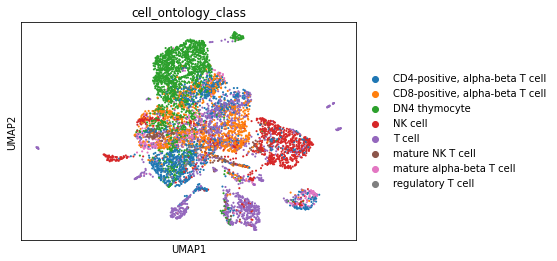

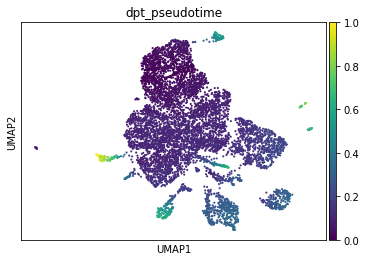

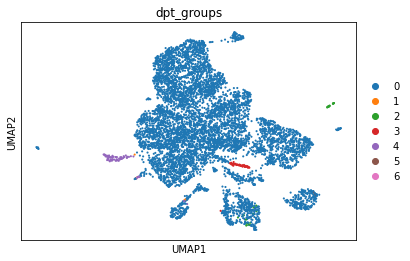

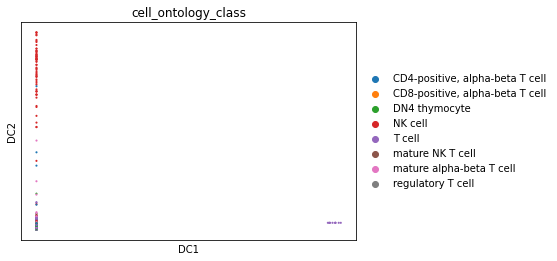

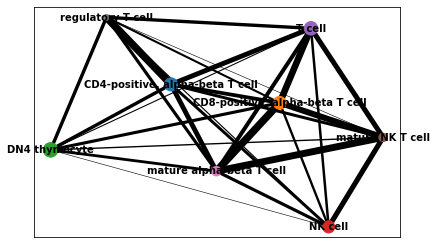

droplet


... storing 'tissue_celltype' as categorical


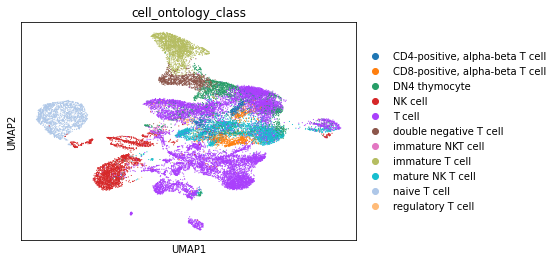

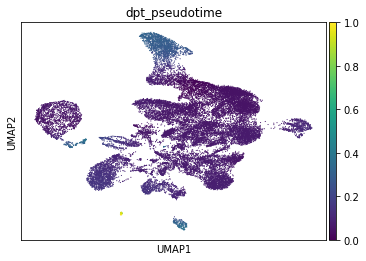

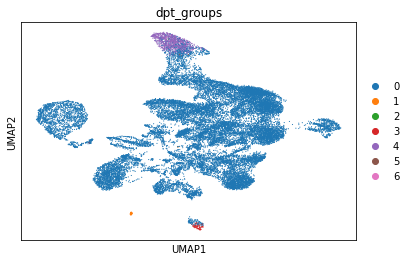

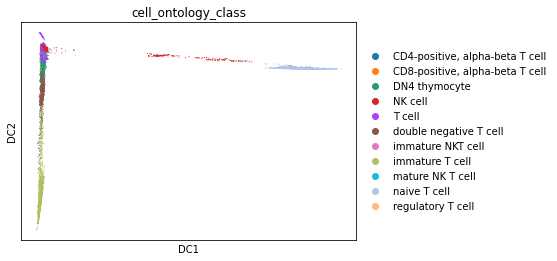

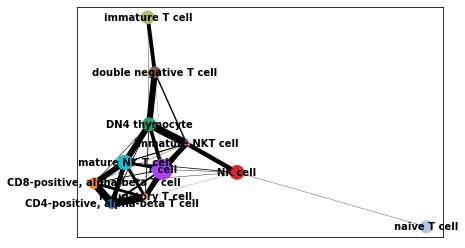

In [130]:
# Reprocess data for this subset of cells
dic_data_reprocessed = {}
for ds in DS_LIST:
    print(ds)
    adata = dic_data_raw[ds][dic_cell_list[ds],:].copy()

    sc.pp.highly_variable_genes(adata, subset = False, min_disp=.5, 
                                min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None)
    sc.pp.scale(adata, max_value=10, zero_center=False)
    sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
    sc.tl.leiden(adata, resolution = 0.5)
    sc.tl.umap(adata)
    sc.tl.diffmap(adata)   
    adata.uns['iroot'] = np.flatnonzero([x=='DN4 thymocyte' for x in adata.obs['cell_ontology_class']])[0]    
    sc.tl.dpt(adata, n_dcs=15, n_branchings=2)
    sc.tl.paga(adata, groups='cell_ontology_class')
    dic_data_reprocessed[ds] = adata.copy()
    
    sc.pl.umap(adata, color='cell_ontology_class')
    sc.pl.umap(adata, color='dpt_pseudotime')
    sc.pl.umap(adata, color='dpt_groups')
    sc.pl.diffmap(adata, color='cell_ontology_class')
    sc.pl.paga(adata)

In [114]:
# ind_select = dic_data_reprocesss['facs'].obs['cell_ontology_class'].isin(['thymocyte', 'DN4 thymocyte'])
# # ind_select = dic_data_reprocesss['facs'].obs['cell_ontology_class'].isin(['DN4 thymocyte'])
# sc.pl.umap(dic_data_reprocesss['facs'][ind_select,:], color=['Cd2', 'Cd5', 'Cd7', 'Cd44', 
#                                                              'Il2ra', 'Kit', 'Cd4', 'Cd8a'])
# sc.pl.umap(dic_data_reprocesss['facs'][ind_select,:], color='cell_ontology_class')

### Analysis: association pattern

In [131]:
dic_trait_assoc_list = {x:[] for x in DS_LIST}

for ds in DS_LIST:
    print('# %s'%DIC_INFO[ds]['dname'])
    for trait in trait_list:
        v_fdr = dic_score[ds].loc[dic_cell_list[ds], '%s.fdr'%trait].values
        if (v_fdr<0.1).sum()>100:
            print('# ', trait, (v_fdr<0.1).sum())
            dic_trait_assoc_list[ds].append(trait)

# TMS FACS
#  UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED 1789
#  PASS_Multiple_sclerosis 720
#  PASS_IBD_deLange2017 348
#  PASS_Rheumatoid_Arthritis 503
#  PASS_AdultOnsetAsthma_Ferreira2019 190
#  UKB_460K.disease_RESPIRATORY_ENT 398
#  UKB_460K.blood_LYMPHOCYTE_COUNT 228
#  UKB_460K.disease_ASTHMA_DIAGNOSED 243
#  PASS_IBD 260
#  UKB_460K.disease_THYROID_ANY_SELF_REP 2696
#  UKB_460K.blood_EOSINOPHIL_COUNT 413
#  UKB_460K.disease_AID_ALL 3145
#  UKB_460K.disease_HYPOTHYROIDISM_SELF_REP 2842
# TMS Droplet
#  UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED 3919
#  PASS_CD_deLange2017 387
#  PASS_Multiple_sclerosis 3788
#  PASS_IBD_deLange2017 1986
#  PASS_Rheumatoid_Arthritis 1064
#  PASS_Ulcerative_Colitis 169
#  PASS_AdultOnsetAsthma_Ferreira2019 387
#  PASS_Crohns_Disease 154
#  UKB_460K.blood_HIGH_LIGHT_SCATTER_RETICULOCYTE_COUNT 182
#  UKB_460K.disease_RESPIRATORY_ENT 1036
#  UKB_460K.blood_MEAN_CORPUSCULAR_HEMOGLOBIN 104
#  UKB_460K.blood_LYMPHOCYTE_COUNT 2557
#  UKB_460K.disease_ASTHM

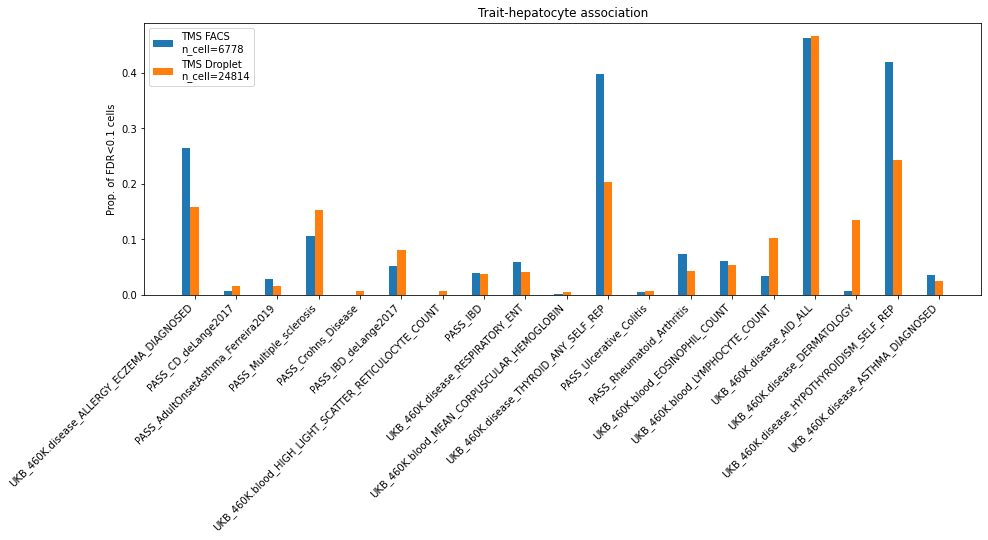

In [132]:
# Overall association pattern
trait_list_plot = list(set(dic_trait_assoc_list['facs']) | 
                       set(dic_trait_assoc_list['droplet']))
df_plot = pd.DataFrame(index=trait_list_plot, columns=['facs', 'droplet'])
dic_n_cell = {}
for trait in trait_list_plot:
    
    cell_list = dic_cell_list['facs']
    dic_n_cell['facs'] = len(cell_list)
    df_plot.loc[trait, 'facs'] = (dic_score['facs'].loc[cell_list, '%s.fdr'%trait]<0.1).mean()
    
    cell_list = dic_cell_list['droplet']
    dic_n_cell['droplet'] = len(cell_list)
    df_plot.loc[trait, 'droplet'] = (dic_score['droplet'].loc[cell_list, '%s.fdr'%trait]<0.1).mean()
df_plot['loc'] = range(df_plot.shape[0])

plt.figure(figsize=[15,5])
plt.bar(df_plot['loc']-0.2, df_plot['facs'], width=0.2, label='TMS FACS\nn_cell=%d'%dic_n_cell['facs'])
plt.bar(df_plot['loc'], df_plot['droplet'], width=0.2, label='TMS Droplet\nn_cell=%d'%dic_n_cell['droplet'])
plt.xticks(df_plot['loc'], df_plot.index, ha='right', rotation=45)
plt.ylabel('Prop. of FDR<0.1 cells')
plt.legend()
plt.title('Trait-hepatocyte association')
plt.show()

### Heterogeneity pattern 

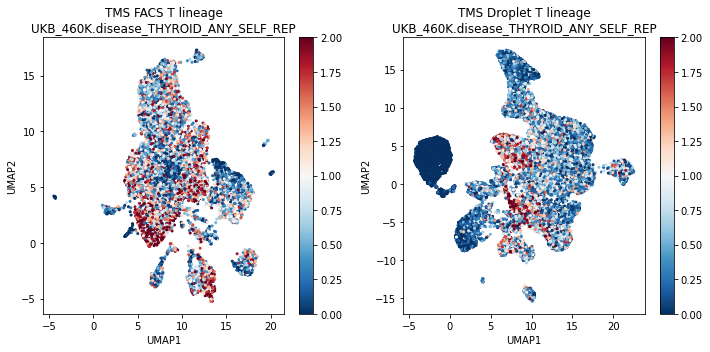

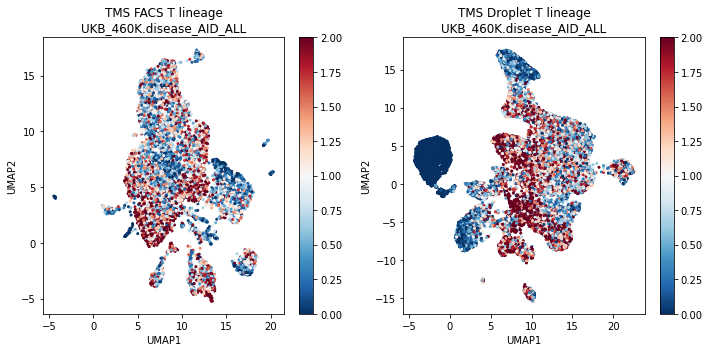

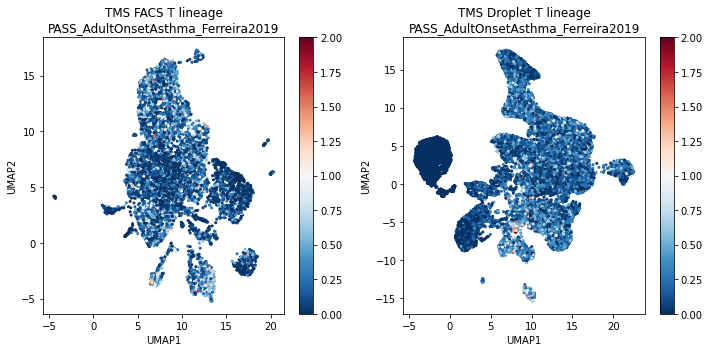

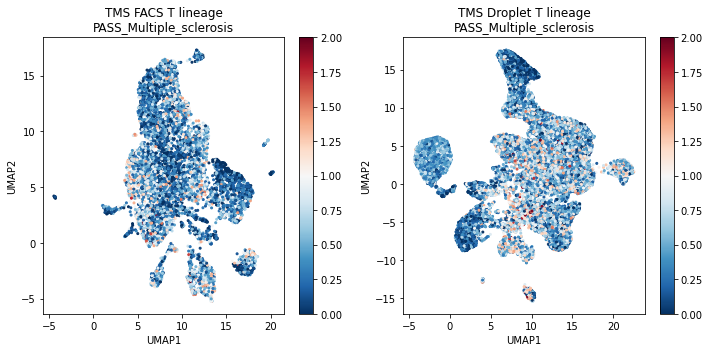

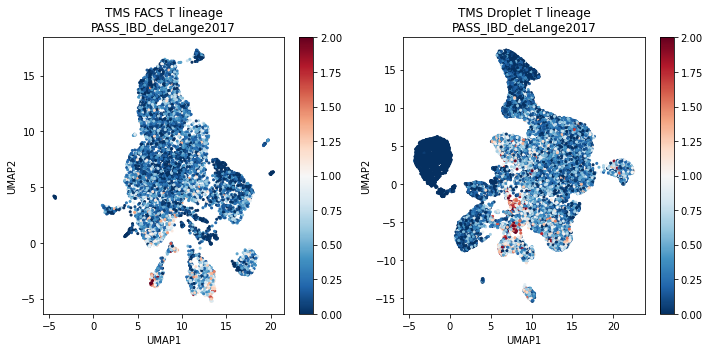

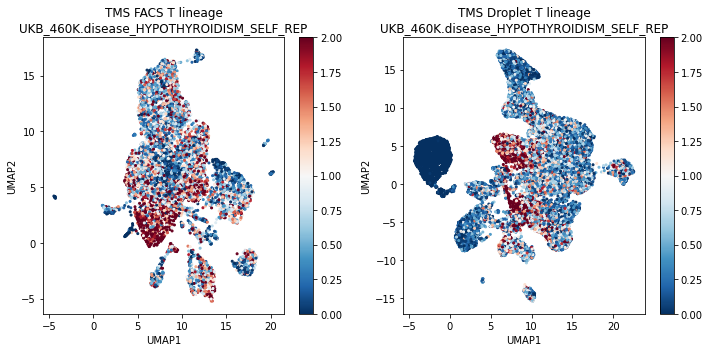

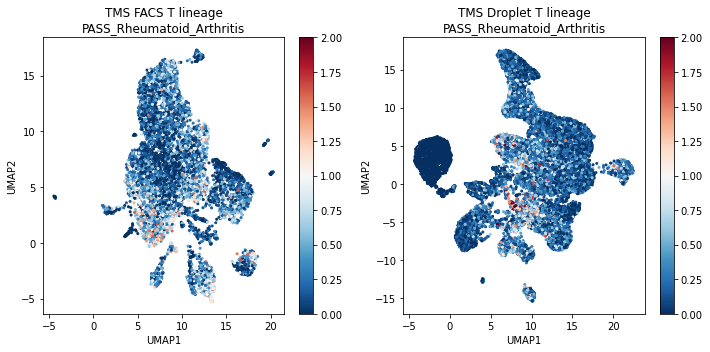

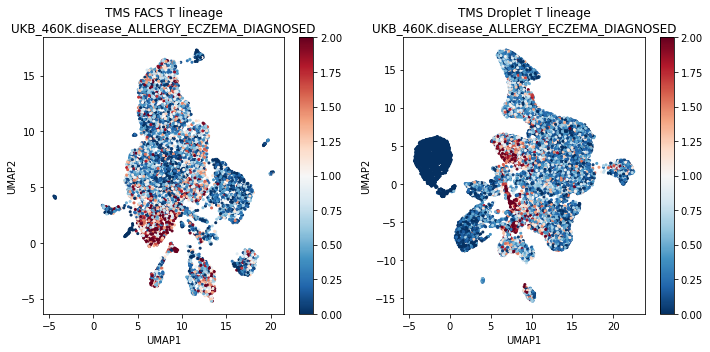

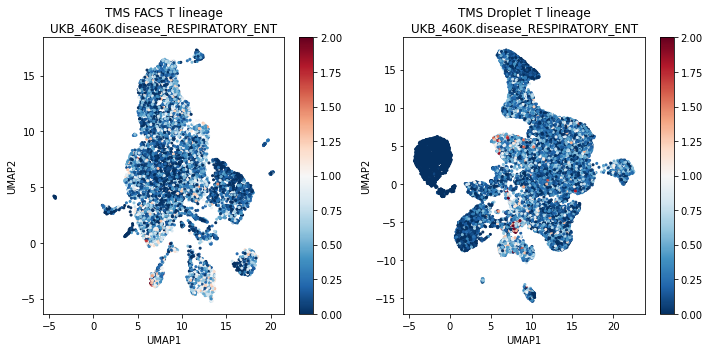

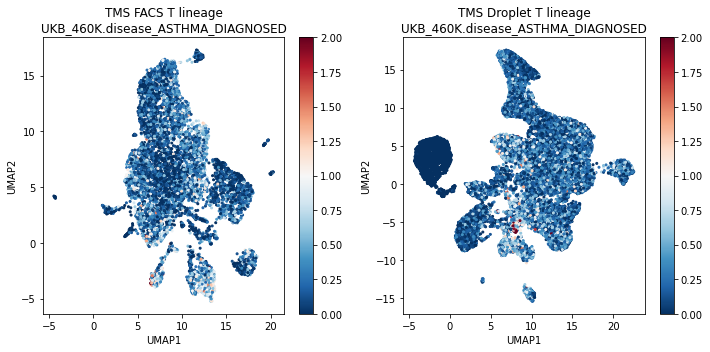

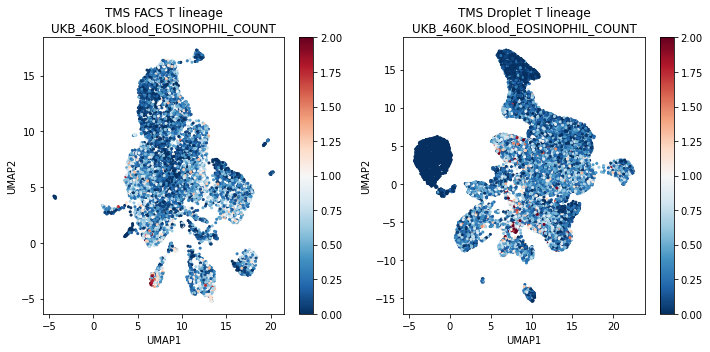

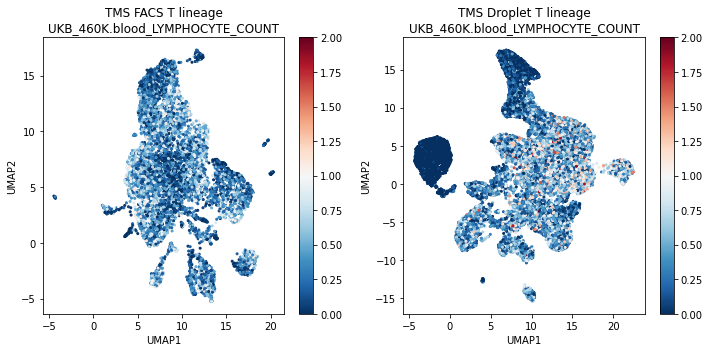

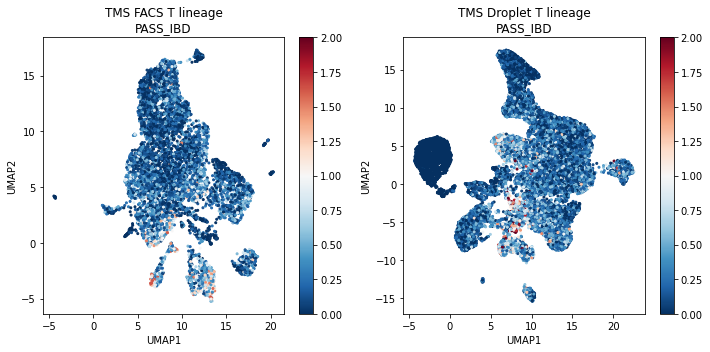

In [133]:
trait_list_plot = list(set(dic_trait_assoc_list['facs']) & 
                       set(dic_trait_assoc_list['droplet']))

for trait in trait_list_plot:
    plt.figure(figsize=[15,5])
    for i_ds,ds in enumerate(DS_LIST):
        
        df_plot = pd.DataFrame(index=dic_data_reprocessed[ds].obs_names,
                               data={'UMAP1':dic_data_reprocessed[ds].obsm['X_umap'][:,0],
                                     'UMAP2':dic_data_reprocessed[ds].obsm['X_umap'][:,1]})
        df_plot = df_plot.loc[dic_cell_list[ds]]
        df_plot = df_plot.join(dic_score[ds]['%s.fdr'%trait])
        df_plot['%s.nlog10_fdr'%trait] = -np.log10(df_plot['%s.fdr'%trait])
        
        plt.subplot(1,3,i_ds+1)
        plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot['%s.nlog10_fdr'%trait],
                    cmap='RdBu_r', vmax=2, vmin=0, s=4)
        plt.colorbar()
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.title('%s T lineage\n%s'%(DIC_INFO[ds]['dname'], trait))
    
    plt.tight_layout()
    plt.show()

### Covariates 

In [135]:
for ds in DS_LIST:
    if 'age' in dic_data_raw[ds].obs.columns:
        dic_data_raw[ds].obs['age_num'] = [int(x.replace('m','')) for x in dic_data_raw[ds].obs['age']]
    dic_data_raw[ds].obs['n_log_count'] = dic_data_raw[ds].X.sum(axis=1)
    dic_data_raw[ds].obs['n_gene'] = (dic_data_raw[ds].X>0).sum(axis=1)

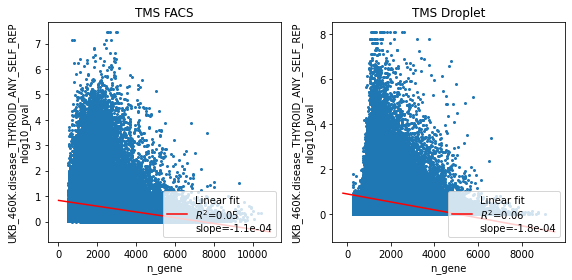

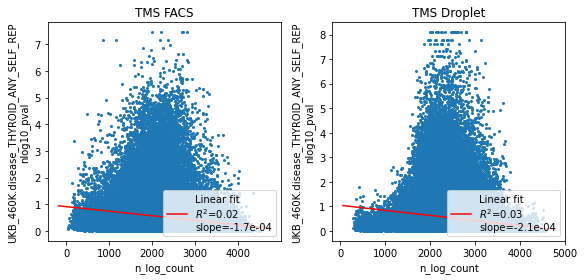

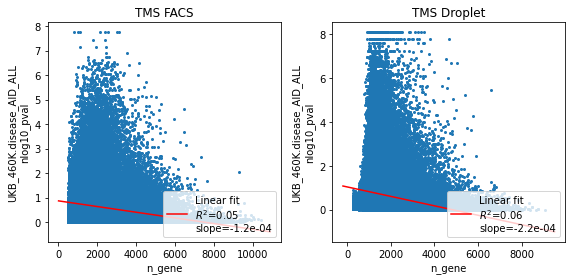

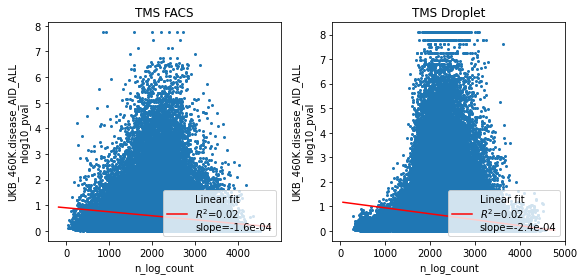

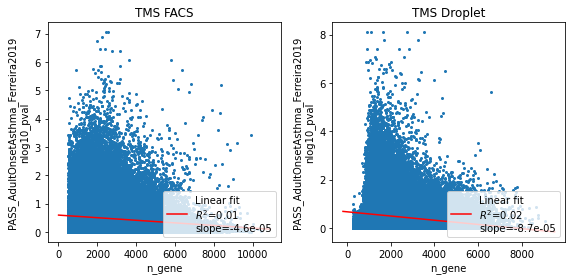

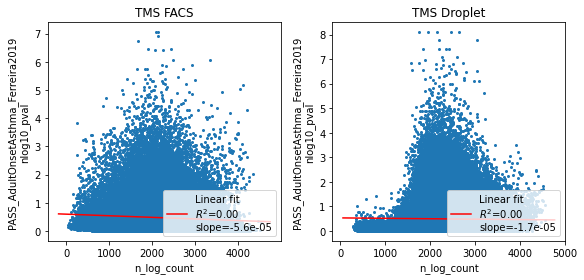

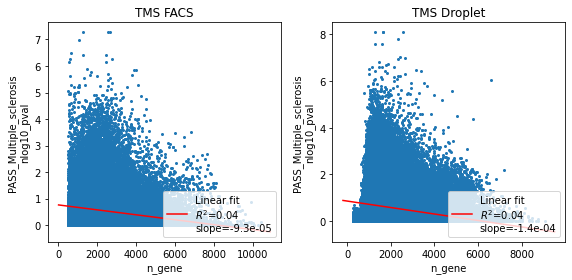

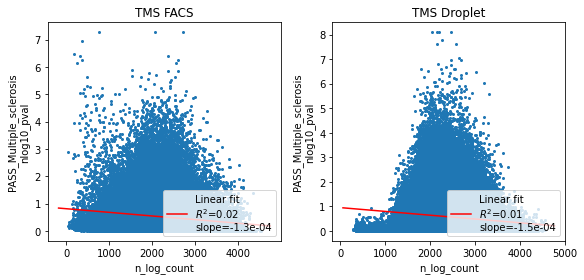

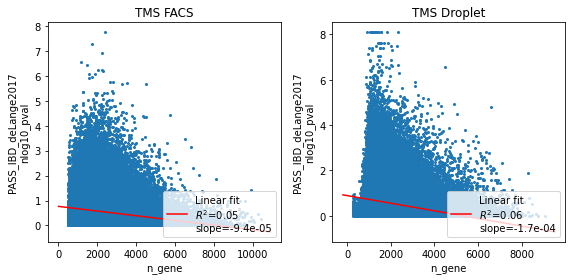

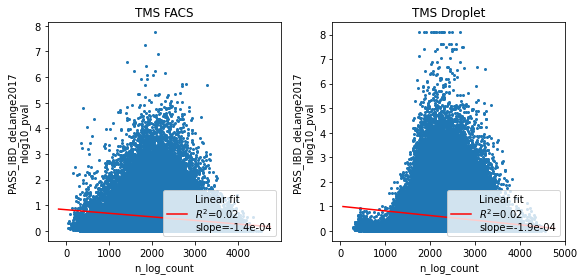

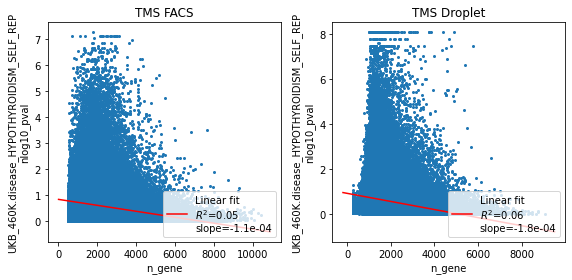

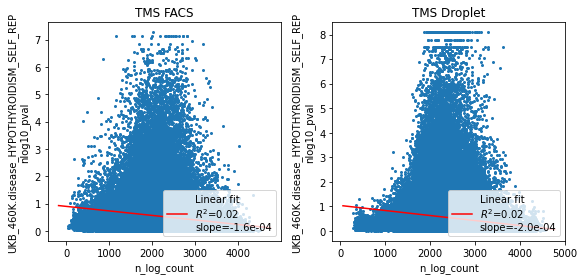

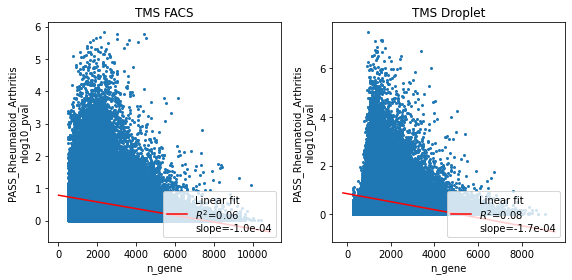

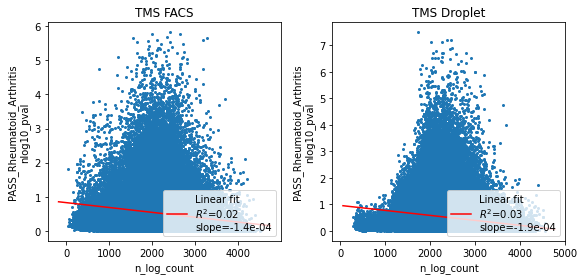

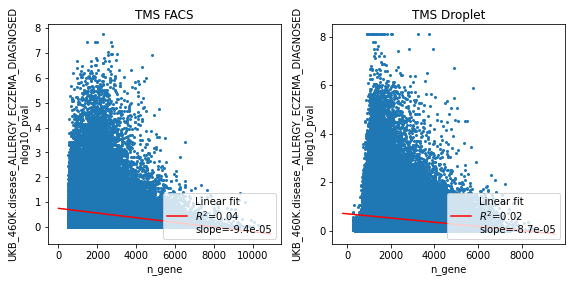

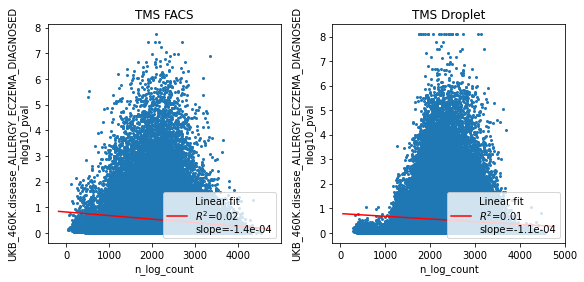

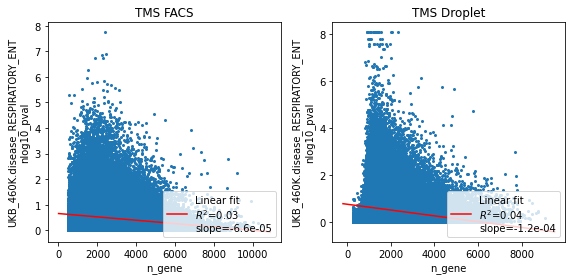

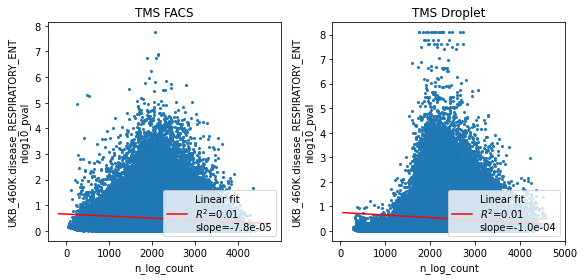

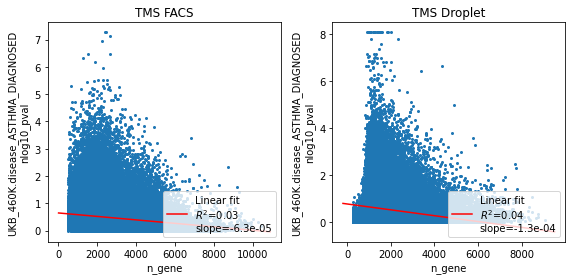

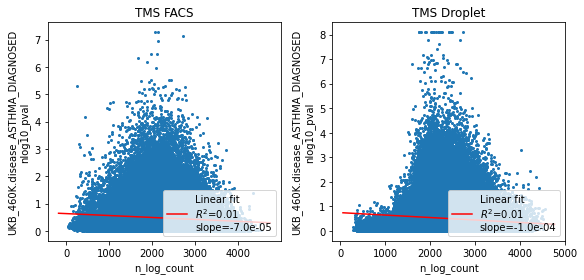

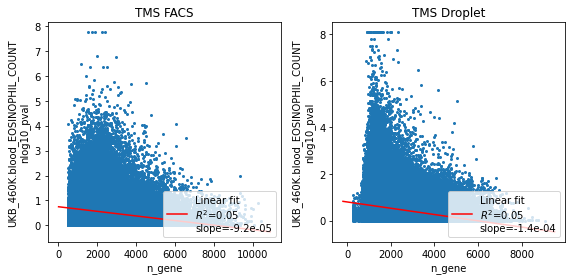

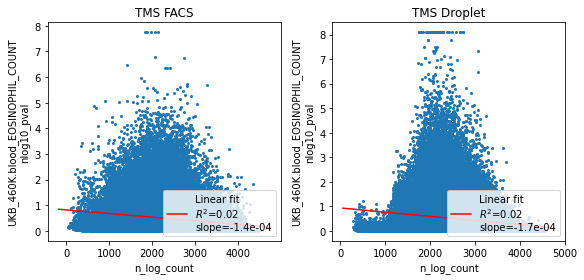

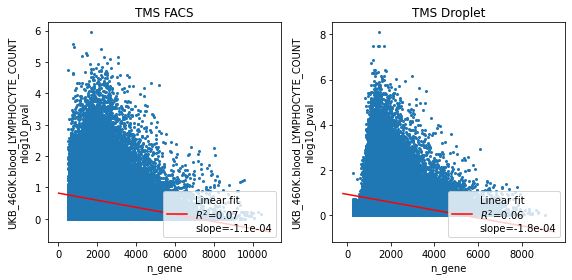

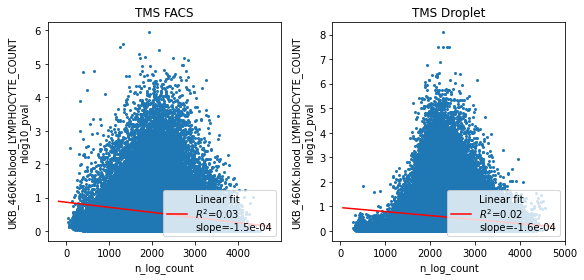

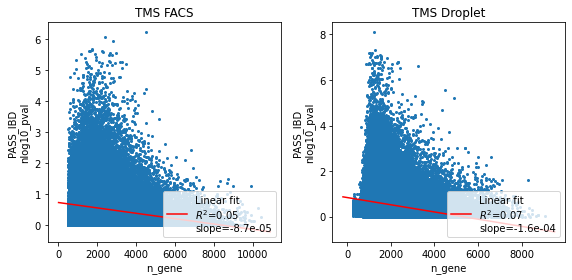

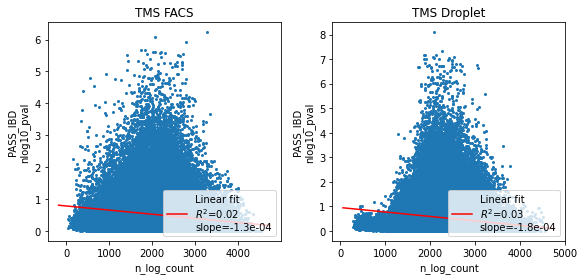

In [138]:
# Overall association
trait_list_plot = list(set(dic_trait_assoc_list['facs']) & 
                       set(dic_trait_assoc_list['droplet']))
cov_list = ['n_gene', 'n_log_count']

for trait in trait_list_plot:
    for cov in cov_list:
        plt.figure(figsize=[12,4])
        for i_ds,ds in enumerate(DS_LIST):
            
            if cov not in dic_data_raw[ds].obs.columns:
                continue
            
            cell_list = list(set(dic_score[ds].index) & set(dic_data_raw[ds].obs.index))
            v_x = dic_data_raw[ds].obs.loc[cell_list, cov].values
            v_y = -np.log10(dic_score[ds].loc[cell_list, '%s.pval'%trait])

            plt.subplot(1,3,i_ds+1)
            plt.scatter(v_x, v_y, s=4)

            # linear fit
            sl, icpt, r_val, p_val, _ = sp.stats.linregress(v_x[v_x>0], v_y[v_x>0])
            x_min,x_max = plt.xlim()
            y_min,y_max = plt.ylim()
            plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
                     label='Linear fit\n$R^2$=%0.2f\nslope=%0.1e'%(r_val**2, sl))
            plt.legend(loc='lower right')

            plt.xlabel(cov)
            plt.ylabel('%s\nnlog10_pval'%trait)
            plt.title(DIC_INFO[ds]['dname'])

        plt.tight_layout()
        plt.show()

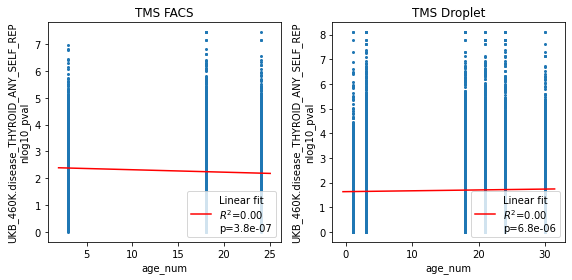

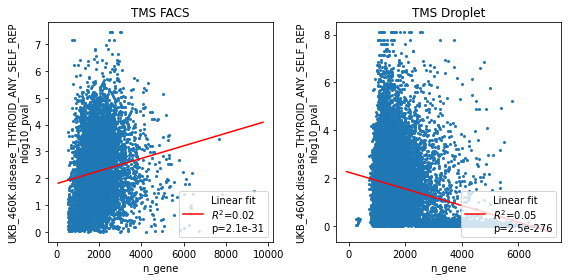

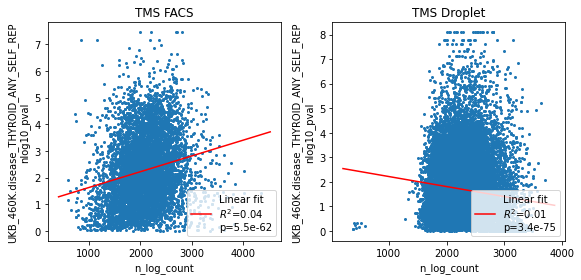

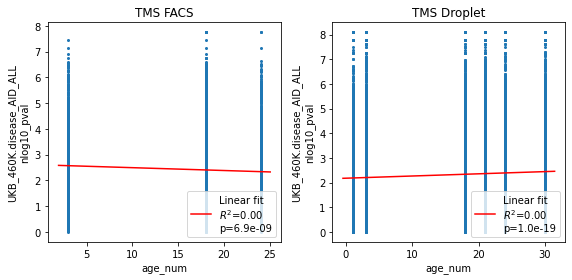

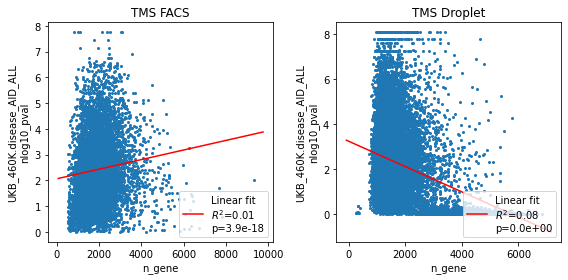

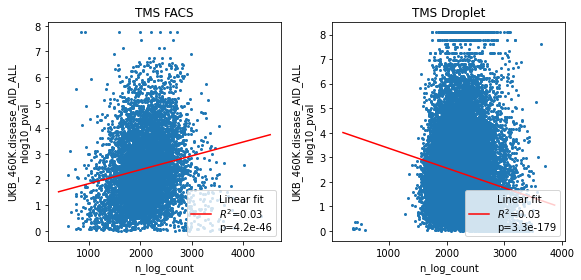

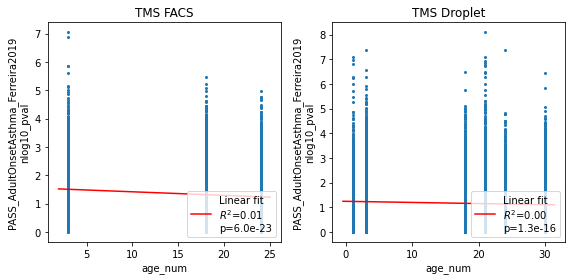

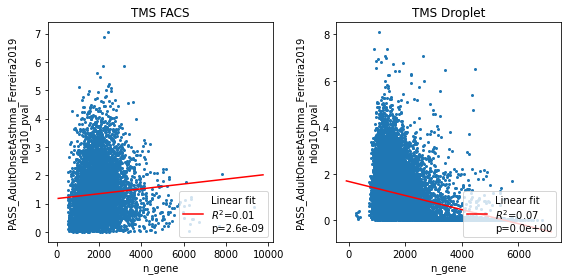

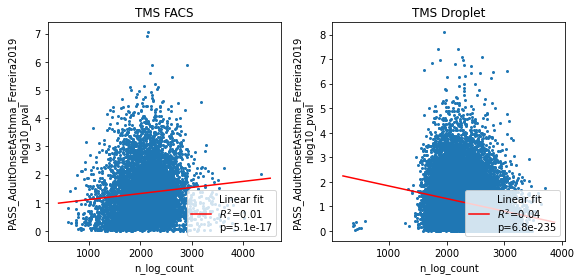

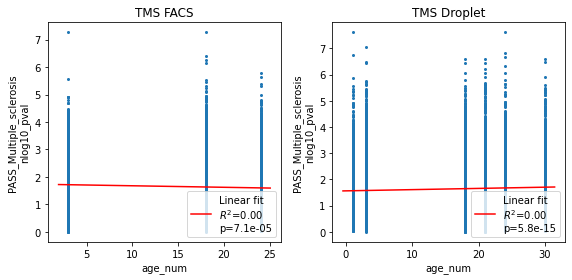

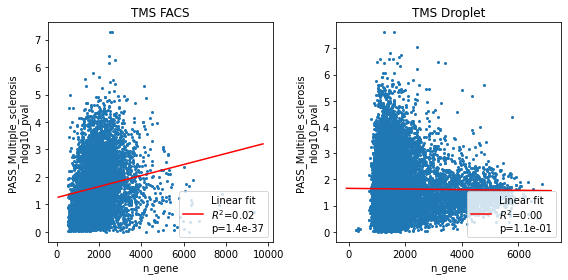

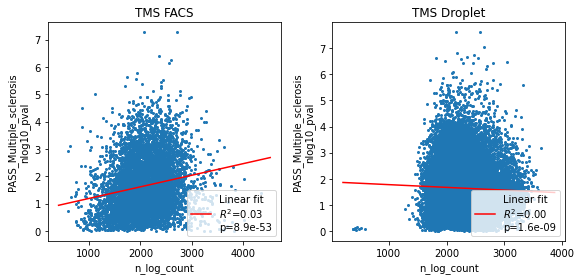

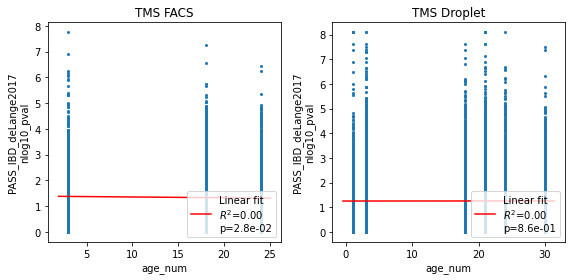

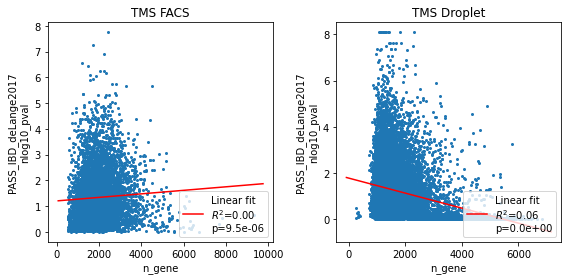

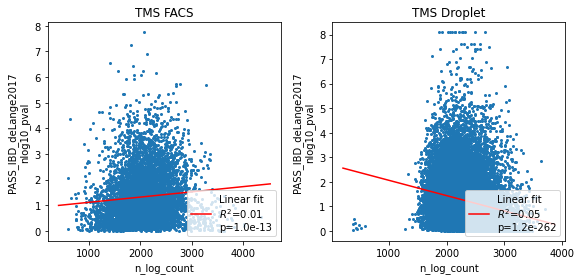

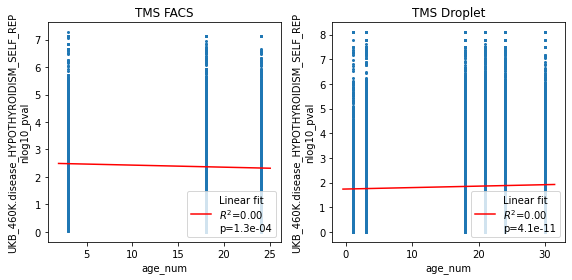

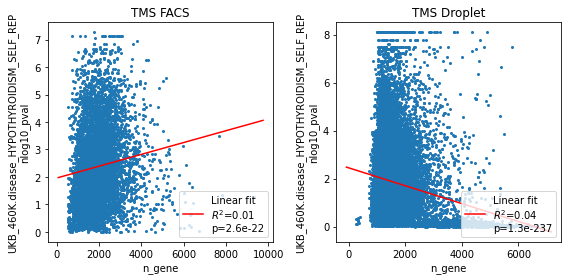

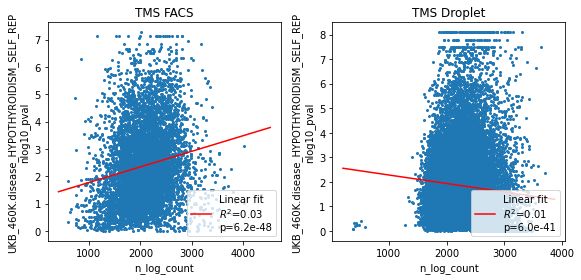

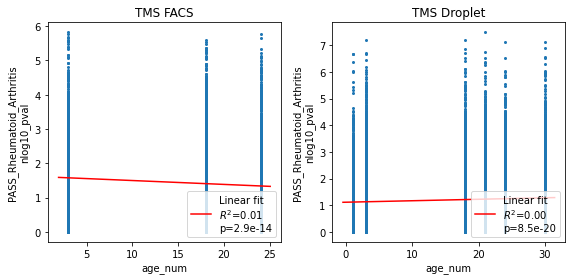

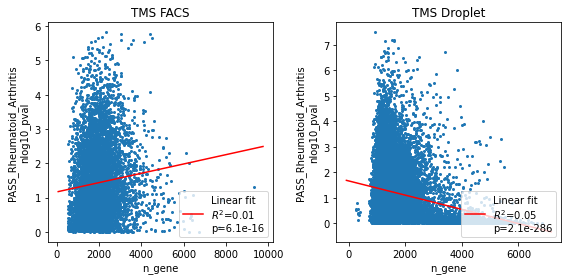

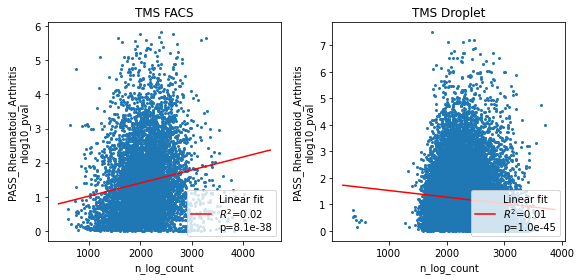

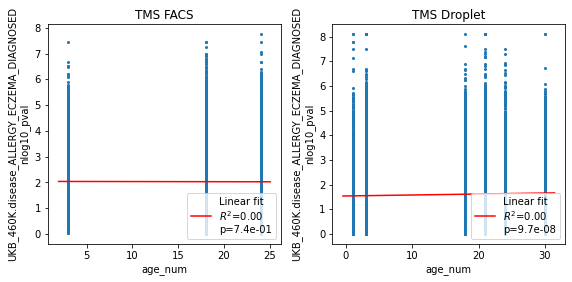

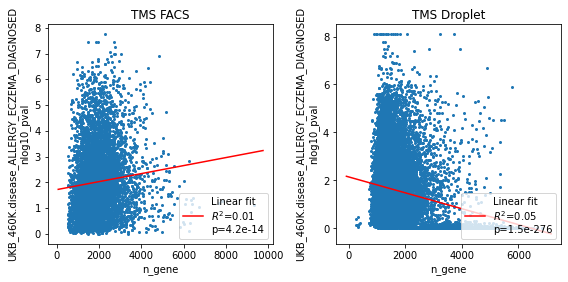

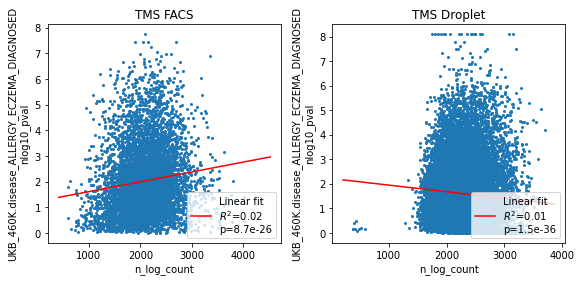

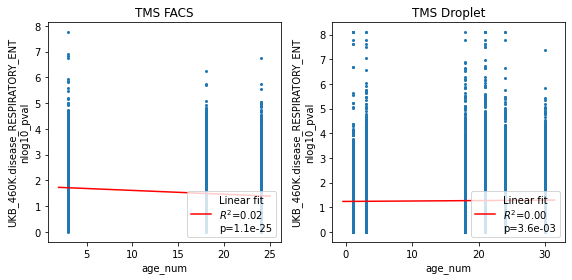

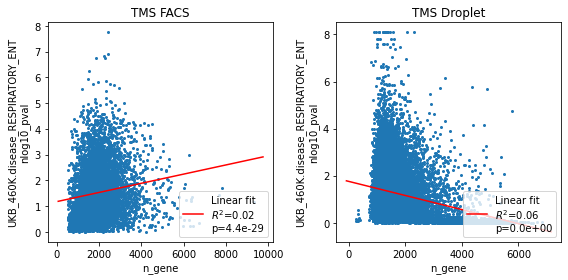

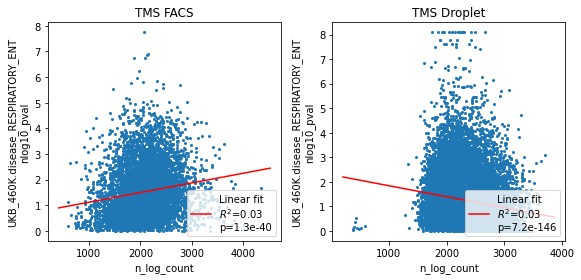

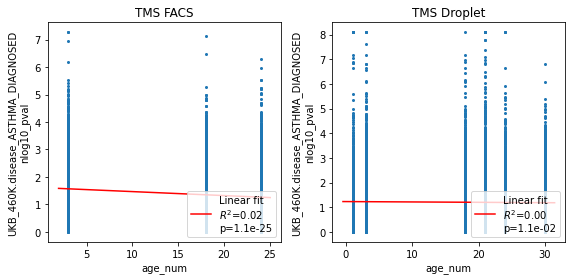

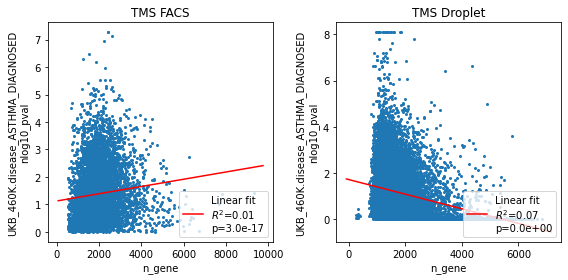

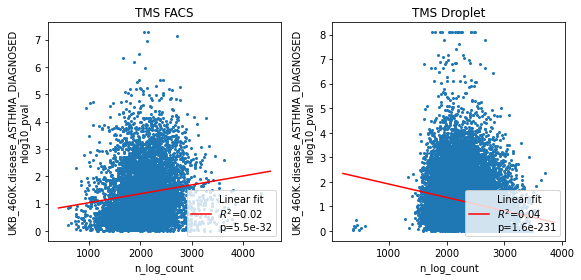

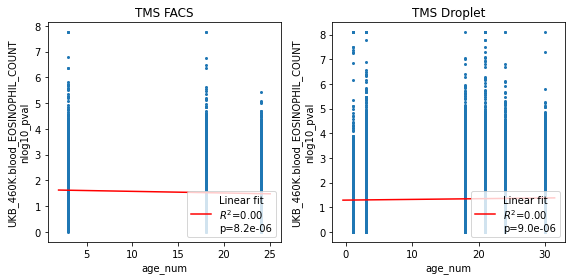

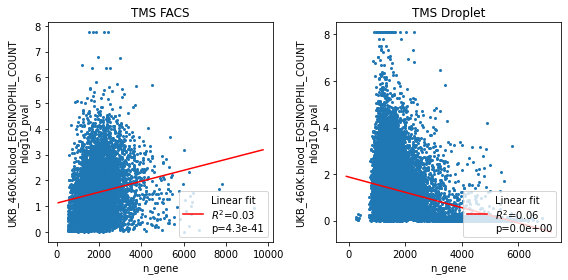

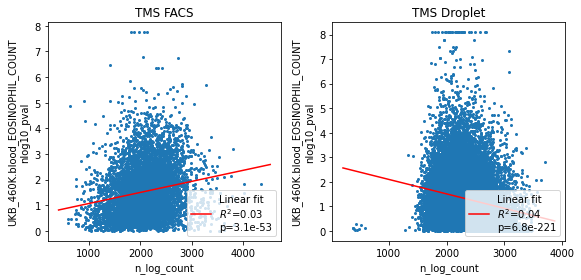

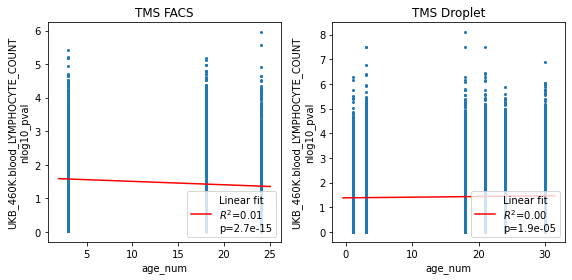

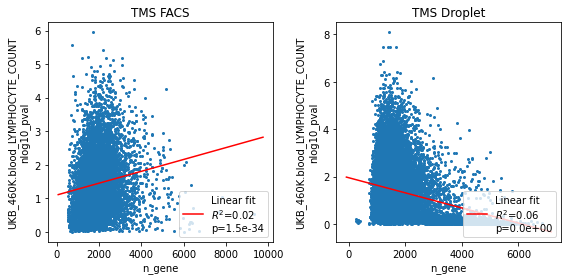

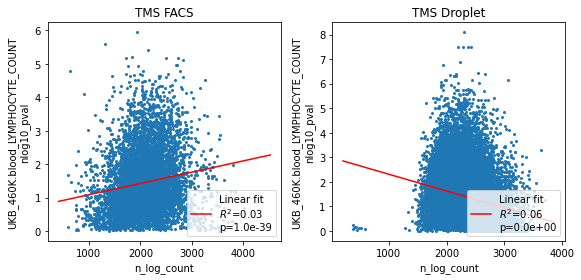

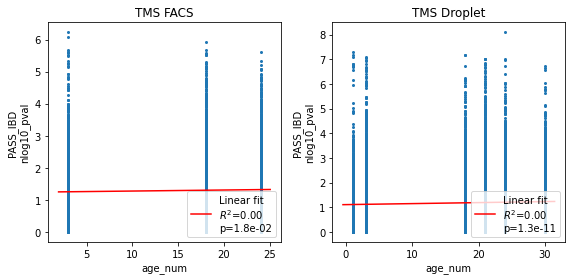

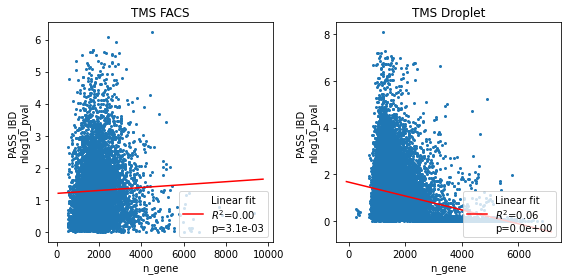

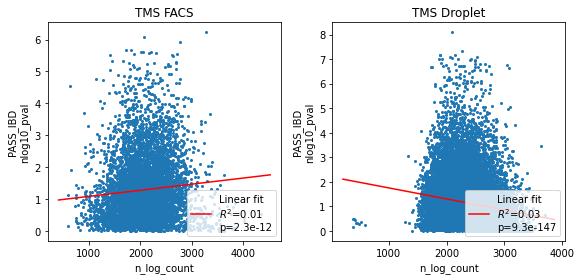

In [139]:
trait_list_plot = list(set(dic_trait_assoc_list['facs']) & 
                       set(dic_trait_assoc_list['droplet']))
cov_list = ['age_num', 'n_gene', 'n_log_count']

for trait in trait_list_plot:
    for cov in cov_list:
        plt.figure(figsize=[12,4])
        for i_ds,ds in enumerate(DS_LIST):
            
            if cov not in dic_data_raw[ds].obs.columns:
                continue

            v_x = dic_data_raw[ds].obs.loc[dic_cell_list[ds], cov].values
            v_y = -np.log10(dic_score[ds].loc[dic_cell_list[ds], '%s.pval'%trait])

            plt.subplot(1,3,i_ds+1)
            plt.scatter(v_x, v_y, s=4)

            # linear fit
            sl, icpt, r_val, p_val, _ = sp.stats.linregress(v_x[v_x>0], v_y[v_x>0])
            x_min,x_max = plt.xlim()
            y_min,y_max = plt.ylim()
            plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
                     label='Linear fit\n$R^2$=%0.2f\np=%0.1e'%(r_val**2, p_val))
            plt.legend(loc='lower right')

            plt.xlabel(cov)
            plt.ylabel('%s\nnlog10_pval'%trait)
            plt.title(DIC_INFO[ds]['dname'])

        plt.tight_layout()
        plt.show()
#         break
#     break

### Various markers 

In [159]:
dic_marker_gene = {}
dic_marker_gene['activation.Il2ra'] = {'hsapiens': 'IL2RA', 'mmusculus':'Il2ra', 'info':'activation'}
dic_marker_gene['activation.Cd69'] = {'hsapiens': 'CD69', 'mmusculus':'Cd69', 'info':'activation'}
dic_marker_gene['activation.Tfrc'] = {'hsapiens': 'Tfrc', 'mmusculus':'Tfrc', 'info':'activation'}
dic_marker_gene['activation.Ctla4'] = {'hsapiens': 'CTLA4', 'mmusculus':'Ctla4', 'info':'activation'}
dic_marker_gene['T cell.Cd3'] = {'hsapiens': 'CD3D', 'mmusculus':'Cd3d', 'info':'T cell'}
dic_marker_gene['CD4_T.Cd4'] = {'hsapiens': 'CD4', 'mmusculus':'Cd4', 'info':'CD4_T'}
dic_marker_gene['CD8_T.Cd8a'] = {'hsapiens': 'CD8A', 'mmusculus':'Cd8a', 'info':'CD8_T'}
dic_marker_gene['Treg.Foxp3'] = {'hsapiens': 'FOXP3', 'mmusculus':'Foxp3', 'info':'Treg'}
dic_marker_gene['senescence.Cdkn2a'] = {'hsapiens': 'CDKN2A', 'mmusculus':'Cdkn2a', 'info':'senescence'}

# check if genes exist:
for gene in dic_marker_gene.keys():
    if dic_marker_gene[gene]['mmusculus'] not in dic_data_raw['facs'].var_names:
        print(dic_marker_gene[gene]['mmusculus'])
    
    if dic_marker_gene[gene]['mmusculus'] not in dic_data_raw['droplet'].var_names:
        print(dic_marker_gene[gene]['mmusculus'])

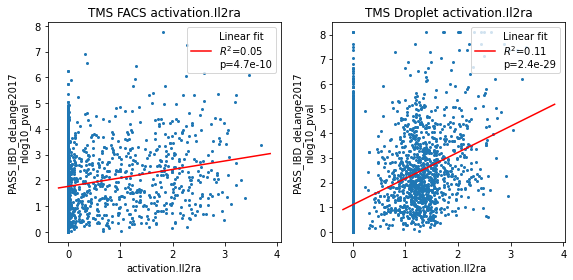

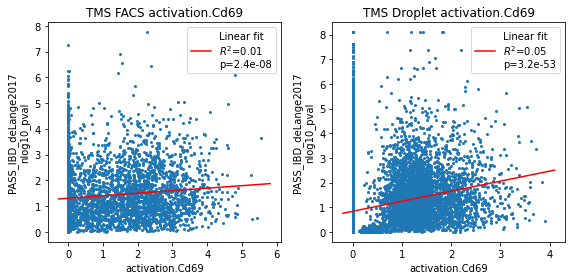

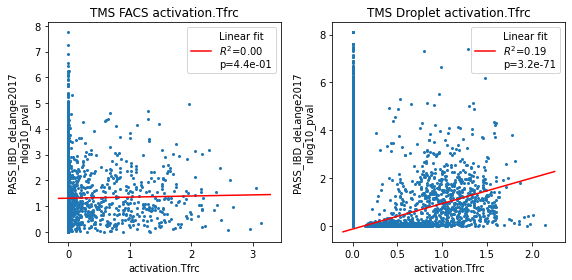

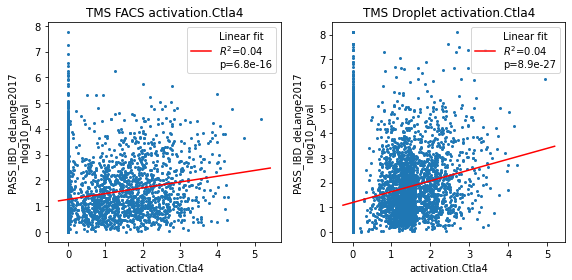

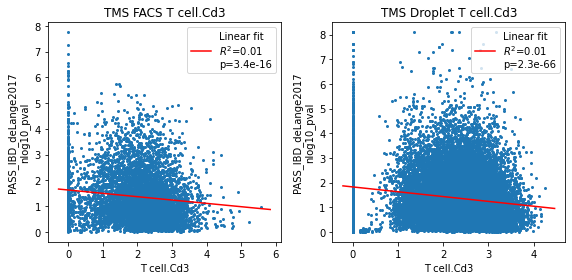

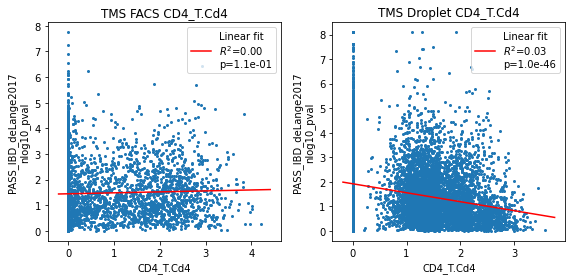

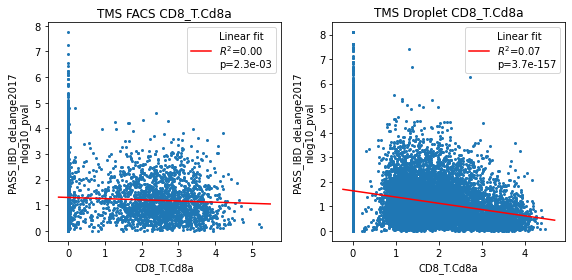

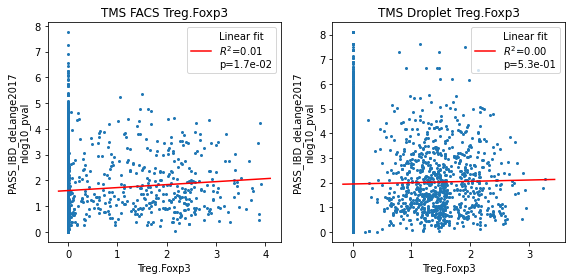

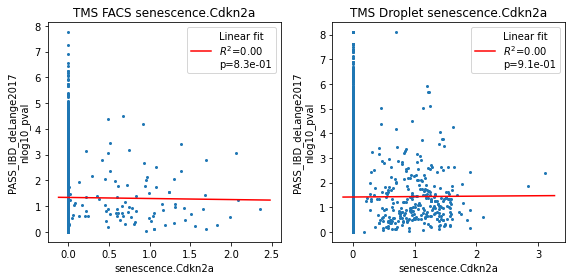

In [160]:
trait = 'PASS_IBD_deLange2017'
for gene in dic_marker_gene.keys():
    plt.figure(figsize=[12,4])
    for i_ds,ds in enumerate(DS_LIST):
        
        if dic_marker_gene[gene][DIC_INFO[ds]['species']] not in dic_data_raw[ds].var_names:
            continue
            
        v_x = dic_data_raw[ds][dic_cell_list[ds], 
                               dic_marker_gene[gene][DIC_INFO[ds]['species']]].X.toarray().reshape([-1])
        v_y = -np.log10(dic_score[ds].loc[dic_cell_list[ds], '%s.pval'%trait])
        
        plt.subplot(1,3,i_ds+1)
        plt.scatter(v_x, v_y, s=4)
        
        # linear fit
        sl, icpt, r_val, p_val, _ = sp.stats.linregress(v_x[v_x>0], v_y[v_x>0])
        x_min,x_max = plt.xlim()
        y_min,y_max = plt.ylim()
        plt.plot([x_min, x_max], [x_min*sl + icpt, x_max*sl + icpt], color='r',
                 label='Linear fit\n$R^2$=%0.2f\np=%0.1e'%(r_val**2, p_val))
        plt.legend(loc='upper right')

        plt.xlabel(gene)
        plt.ylabel('%s\nnlog10_pval'%trait)
        plt.title('%s %s'%(DIC_INFO[ds]['dname'], gene))

    plt.tight_layout()
    plt.show()
#     break

### Pathway

In [147]:
from gprofiler import GProfiler

dic_pathway = {}
trait = 'PASS_IBD_deLange2017'
for i_ds,ds in enumerate(DS_LIST):
    
    print(ds)
    adata_small=dic_data_raw[ds][dic_cell_list[ds], :].copy()
    adata_small.obs['group'] = (dic_score[ds].loc[dic_cell_list[ds], '%s.fdr'%trait]<0.1)
#     adata_small.obs['group'] = ['assoc' if x else 'non-assoc' for x in adata_small.obs['group']]
    adata_small.obs['group'] = ['assoc' if x&(y<2000) else 'non-assoc' 
                                for x,y in zip(adata_small.obs['group'], adata_small.obs['n_gene'])]
    adata_small.obs['group'] = adata_small.obs['group'].astype('category')
    sc.tl.rank_genes_groups(adata_small, groupby='group', method='t-test_overestim_var')
#     sc.pl.rank_genes_groups_heatmap(adata_small)
    
    gp = GProfiler(return_dataframe=True)
    df_pathway = gp.profile(organism=DIC_INFO[ds]['species'], 
                            query=list(adata_small.uns['rank_genes_groups']['names']['assoc']),
                            sources=['KEGG', 'GO:BP', 'REAC'],
                            significance_threshold_method='fdr', 
                            user_threshold=0.01,
                            background=list(dic_data_raw[ds].var_names))
    ind_select = (df_pathway['term_size']<500) & (df_pathway['term_size']>5) & (df_pathway['intersection_size']>10)
    dic_pathway['%s.%s.assoc'%(ds, trait)] = df_pathway.loc[ind_select].copy()
    
    gp = GProfiler(return_dataframe=True)
    df_pathway = gp.profile(organism=DIC_INFO[ds]['species'], 
                            query=list(adata_small.uns['rank_genes_groups']['names']['non-assoc']),
                            sources=['KEGG', 'GO:BP', 'REAC'],
                            significance_threshold_method='fdr', 
                            user_threshold=0.01,
                            background=list(dic_data_raw[ds].var_names))
    ind_select = (df_pathway['term_size']<500) & (df_pathway['term_size']>5) & (df_pathway['intersection_size']>10)
    dic_pathway['%s.%s.non-assoc'%(ds, trait)] = df_pathway.loc[ind_select].copy()
    

for term in dic_pathway.keys():
    dic_pathway[term].index = ['%s.%s'%(x,y) for x,y in zip(dic_pathway[term]['source'], dic_pathway[term]['name'])]

facs


... storing 'tissue_celltype' as categorical


droplet


... storing 'tissue_celltype' as categorical


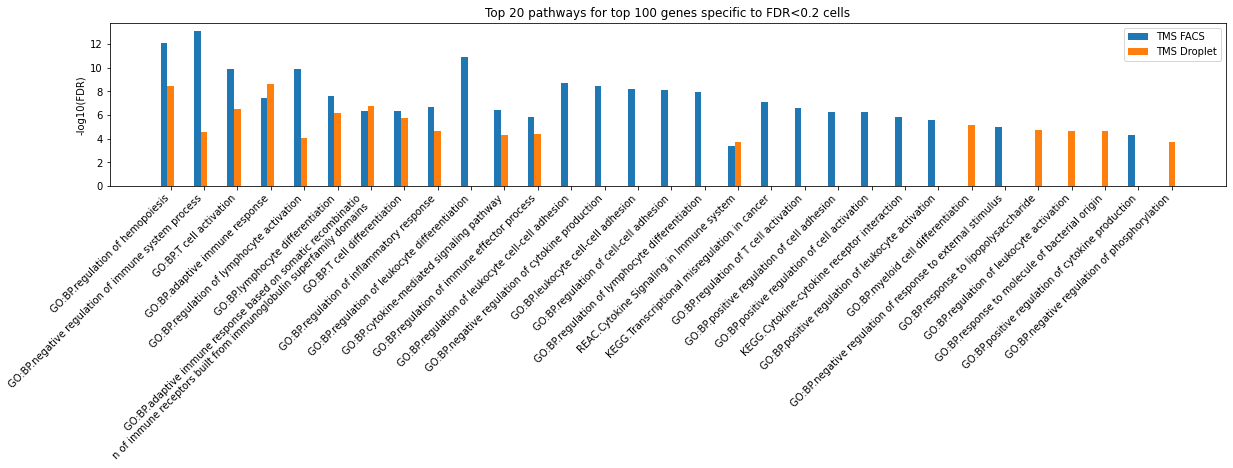

In [150]:
# Cross comparision: assoc-pathways 
temp_list = []
for i_ds,ds in enumerate(DS_LIST):
    temp_list.extend(dic_pathway['%s.%s.assoc'%(ds, trait)].index)
df_plot = pd.DataFrame(index=sorted(set(temp_list)), columns=['facs', 'droplet', 'aizarani'], data=0)
for i_ds,ds in enumerate(DS_LIST):
    term_list = list(set(df_plot.index) & set(dic_pathway['%s.%s.assoc'%(ds, trait)].index))
    df_plot.loc[term_list, ds] = -np.log10(dic_pathway['%s.%s.assoc'%(ds, trait)].loc[term_list,'p_value'].values)
df_plot['mean'] = df_plot.mean(axis=1)
# df_plot = df_plot.loc[df_plot['mean']>5]
df_plot = df_plot.sort_values(by=['mean'], ascending=False).iloc[:40,:]
df_plot['loc'] = range(df_plot.shape[0])
df_plot.index = [x[:60]+'\n'+x[60:] if len(x)>80 else x for x in df_plot.index]

plt.figure(figsize=[20,3])
plt.bar(df_plot['loc']-0.2, df_plot['facs'], width=0.2, label='TMS FACS')
plt.bar(df_plot['loc'], df_plot['droplet'], width=0.2, label='TMS Droplet')
# plt.bar(df_plot['loc']+0.2, df_plot['aizarani'], width=0.2, label='Human liver')
plt.xticks(df_plot['loc'], df_plot.index, ha='right', rotation=45)
plt.ylabel('-log10(FDR)')
plt.legend()
plt.title('Top 20 pathways for top 100 genes specific to FDR<0.2 cells')
plt.show()

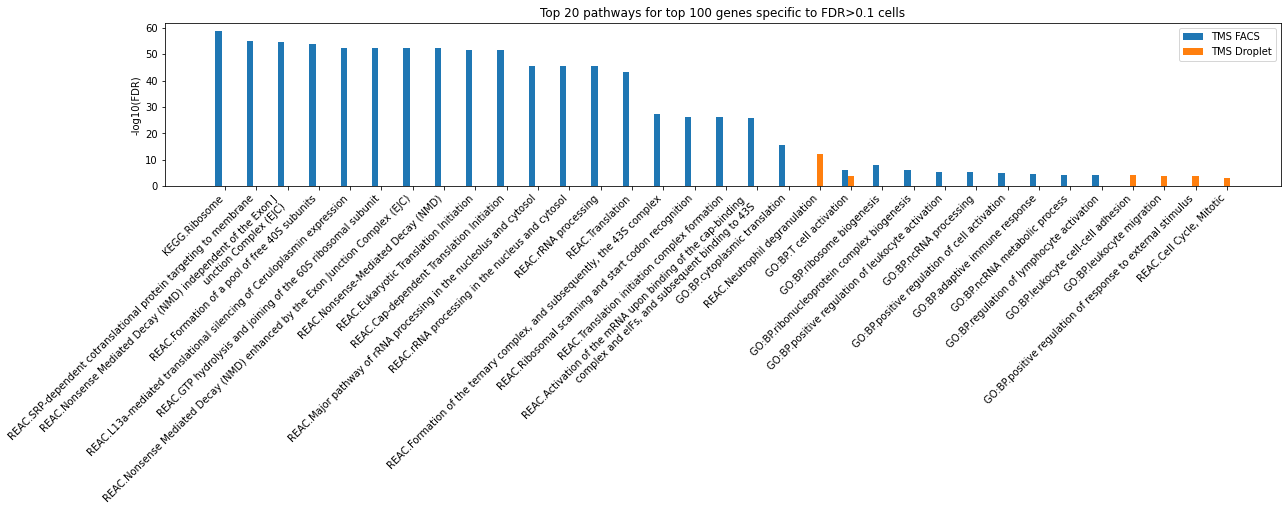

In [151]:
# Cross comparision: non-assoc-pathways 
temp_list = []
for i_ds,ds in enumerate(DS_LIST):
    temp_list.extend(dic_pathway['%s.%s.non-assoc'%(ds, trait)].index)
df_plot = pd.DataFrame(index=sorted(set(temp_list)), columns=['facs', 'droplet', 'aizarani'], data=0)
for i_ds,ds in enumerate(DS_LIST):
    term_list = list(set(df_plot.index) & set(dic_pathway['%s.%s.non-assoc'%(ds, trait)].index))
    df_plot.loc[term_list, ds] = -np.log10(dic_pathway['%s.%s.non-assoc'%(ds, trait)].loc[term_list,'p_value'].values)
df_plot['mean'] = df_plot.mean(axis=1)
# df_plot = df_plot.loc[df_plot['mean']>5]
df_plot = df_plot.sort_values(by=['mean'], ascending=False).iloc[:40,:]
df_plot['loc'] = range(df_plot.shape[0])
df_plot.index = [x[:60]+'\n'+x[60:] if len(x)>80 else x for x in df_plot.index]

plt.figure(figsize=[20,3])
plt.bar(df_plot['loc']-0.2, df_plot['facs'], width=0.2, label='TMS FACS')
plt.bar(df_plot['loc'], df_plot['droplet'], width=0.2, label='TMS Droplet')
# plt.bar(df_plot['loc']+0.2, df_plot['aizarani'], width=0.2, label='Human liver')
plt.xticks(df_plot['loc'], df_plot.index, ha='right', rotation=45)
plt.ylabel('-log10(FDR)')
plt.legend()
plt.title('Top 20 pathways for top 100 genes specific to FDR>0.1 cells')
plt.show()
    